# Context dependence test

In [1]:
from creme import creme
from creme import utils
import custom_model
import pandas as pd
import matplotlib.pyplot as plt

2024-06-05 03:10:53.417258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load Enformer and example sequences

In [2]:
data_dir = '../../../data/'
track_index = [5111]
model = custom_model.Enformer(track_index=track_index)

2024-06-05 03:11:17.513393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 03:11:17.948861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 69489 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [3]:
fasta_path = f'{data_dir}/GRCh38.primary_assembly.genome.fa'
seq_parser = utils.SequenceParser(fasta_path)

genes = ['ABCA8_chr17_68955392_-', 'NFKBIZ_chr3_101849513_+']
gene_seqs = {}

for gene in genes:
    gene_name, chrom, start, strand = gene.split('_')
    seq = seq_parser.extract_seq_centered(chrom, int(start), strand, model.seq_length)
    gene_seqs[gene_name] = seq

In [12]:
# TSS bin indeces
bins = [447, 448]

In [4]:
abca8_wt = model.predict(gene_seqs['ABCA8'])[0,:,0]
nfkbiz_wt = model.predict(gene_seqs['NFKBIZ'])[0,:,0]

2024-06-05 03:11:20.967107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-05 03:11:21.135040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


<Axes: >

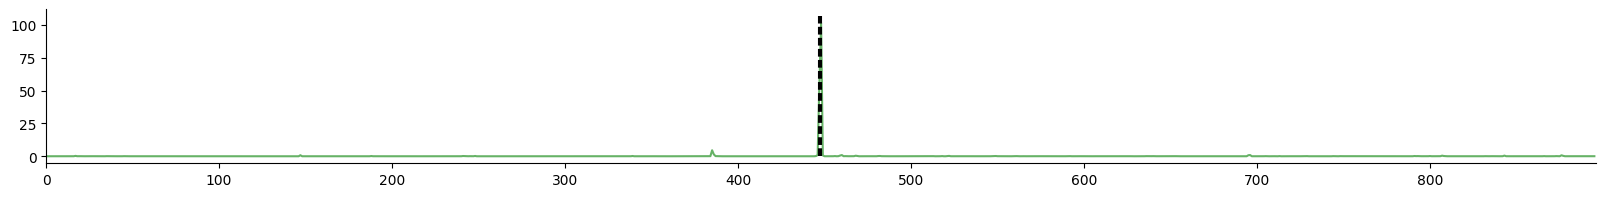

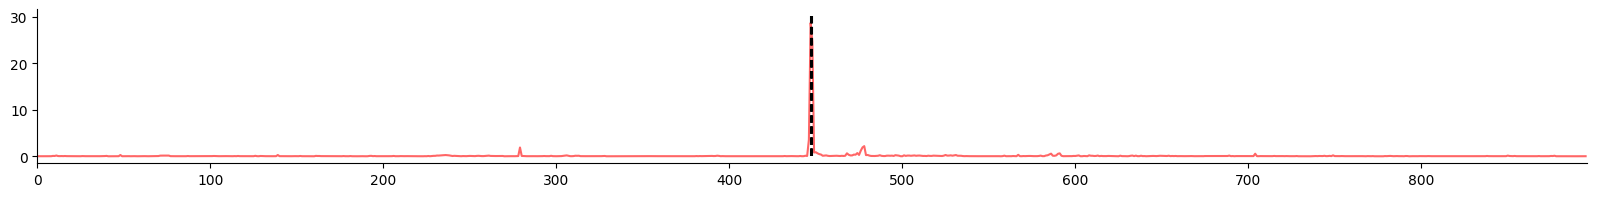

In [13]:
utils.plot_track([abca8_wt], color='green', zoom=[0, 896], marks=bins)
utils.plot_track([nfkbiz_wt], color='red', zoom=[0, 896], marks=bins)

**Context dependence test**

To run context dependence test we need:
- a loaded model
- onehot encoded sequence (WT)
- a coordinate interval where the TSS
- number of times to run the shuffling
- optionally, we can choose if the results will be summarized or the results of each shuffle will be returned
- optionally, we can omit getting WT predictions to save time 

In [6]:
seq_halflen = model.seq_length // 2
half_window_size = 2500
N_shuffles = 10

Enhancing context sequence: this is an example sequence with enhancing context, where shuffling the sequence context leads to a drop in TSS activity.


In [7]:
_, pred_mut = creme.context_dependence_test(model, gene_seqs['ABCA8'],
                                            [seq_halflen - half_window_size, seq_halflen + half_window_size],
                                            N_shuffles, mean=False, drop_wt=True)

<Axes: >

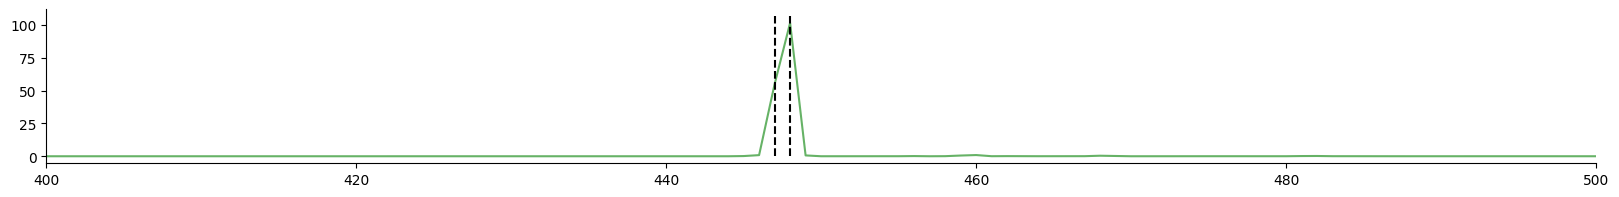

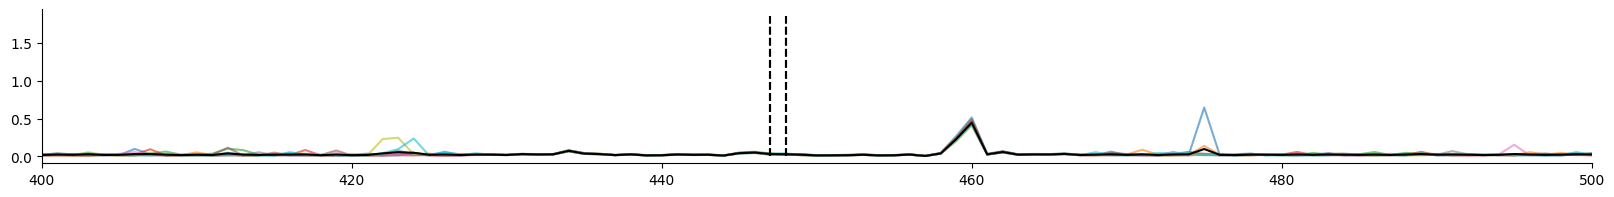

In [15]:
utils.plot_track([abca8_wt], color='green', zoom=[400, 500], marks=bins)
ax=utils.plot_track(pred_mut[:,:,0], zoom=[400, 500], marks=bins)
utils.plot_track([pred_mut[:,:,0].mean(axis=0)], alpha=1, color='k', zoom=[400, 500], marks=bins, ax=ax)

Silencing context sequence: this is an example sequence with silencing context, where shuffling the sequence context leads to an increase in TSS activity.

In [16]:
_, pred_mut = creme.context_dependence_test(model, gene_seqs['NFKBIZ'],
                                                            [seq_halflen - half_window_size, seq_halflen + half_window_size],
                                                            N_shuffles, mean=False, drop_wt=True)

<Axes: >

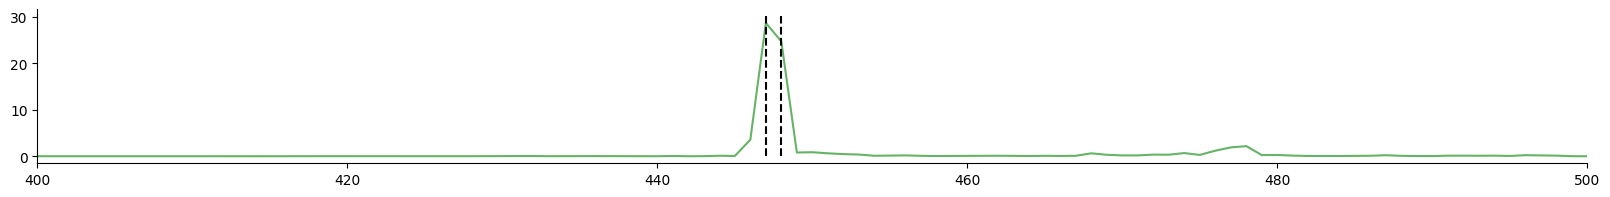

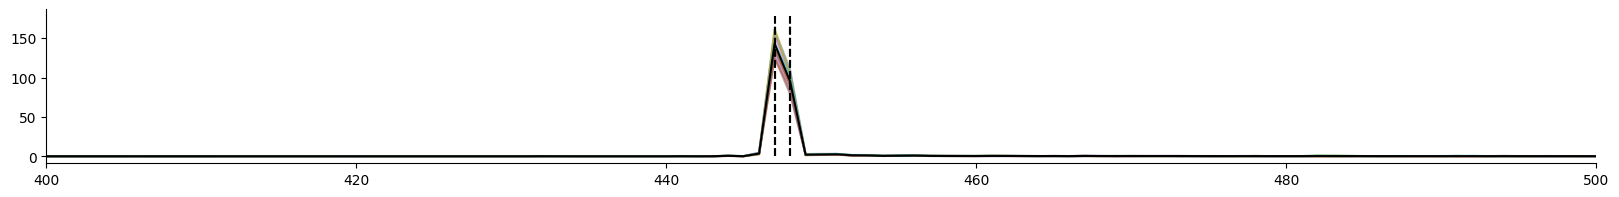

In [18]:
utils.plot_track([nfkbiz_wt], color='green', zoom=[400, 500], marks=bins)
ax=utils.plot_track(pred_mut[:,:,0], zoom=[400, 500], marks=bins)
utils.plot_track([pred_mut[:,:,0].mean(axis=0)], alpha=1, color='k', zoom=[400, 500], marks=bins, ax=ax)